## Linear models for predicting MLB salary in 6 years with rookie stats

### Future notes / todos
* Distribution of log(salary) is somewhat normal. Need to confirm if this is OK or not.
* Should put age into feature set and see if the younger the rookie then better chance of a higher salary.
* Need some type of pairplot as probably some of my features are correlated like HRs and TBs.
* Probably need to get more data

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from  matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
# set paths of the data files
PATH_S = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/hist_salaries.csv'
PATH_R = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/rookies.csv'
PATH_RS = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/agg_df_stats.csv'

In [3]:
def mean_mse_Lasso(model,name):
    mse = model.get_params()[name].mse_path_
    alphas = model.get_params()[name].alphas_
    mse_df = pd.DataFrame(data=mse, index=alphas)
    return mse_df.loc[model.get_params()[name].alpha_].mean()

In [4]:
def mean_mse_Ridge(model,name):
    mse = model.get_params()[name].mse_path_
    alphas = model.get_params()[name].alphas_
    mse_df = pd.DataFrame(data=mse, index=alphas)
    return mse_df.loc[model.get_params()[name].alpha_].mean()

In [5]:
# get the salary and stats data
df_stats = pd.read_csv(PATH_RS, index_col = 0)
df_salary = pd.read_csv(PATH_S, index_col = 0)

Merge the stats and salary data frames together. `df_stats` has only rookie batters from 1985-2017. `df_salary` has all MLB salaries from 1985-2017 as long as the player was paid for 6 years from rookie season.

In [6]:
salary_stats_df = df_stats.merge(df_salary, on='name_year')
salary_stats_df = salary_stats_df.loc[:,['Year_x', 'Age_x', 'name_x', 'debut', 'position', 'G', 'PA', 'AB', 'R',
       'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'name_year',
        'Salary', 'SrvTm', 'today_salary']]
salary_stats_df.rename(columns={'Year_x':'rookie_year', 'Age_x':'age', 'name_x':'name'}, inplace=True)
salary_stats_df['log_today_salary'] = np.log10(salary_stats_df.today_salary) # log transform the salary
salary_stats_df.shape

(919, 23)

Create `X` and `y`, and make a train / test split of 20%.

In [7]:
y = salary_stats_df.log_today_salary

X = salary_stats_df.loc[:,['G', 'PA', 'AB', 'R', 'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'age']]
print('X sample:',X.shape)
print('y sample:',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

print('X train:', X_train.shape)
print('y train:', y_train.shape)

X sample: (919, 14)
y sample: (919,)
X train: (735, 14)
y train: (735,)


Combine `X` and `y` training data sets and calculate the correlation matrix.

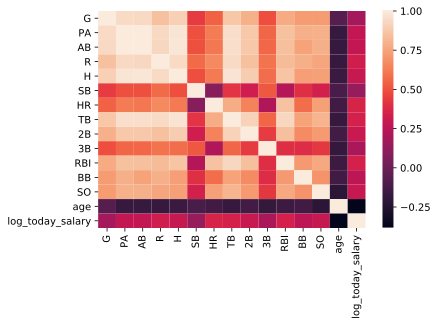

In [8]:
Xy = pd.concat([X_train, y_train], axis=1)
# sns.pairplot(Xy);

corr = Xy.corr()
sns.heatmap(corr);

HRs and age of rookie year are somewhat correlated with salary in 6 years. Whereas, games (G) and stolen bases (SB) are less related to salary in 6 years.

Build a basic linear regression model with all features as a baseline to compare against the Lasso models

In [9]:
model_results = pd.Series(name='MSE')

Add a 10-fold cross-validation linear regression model.

In [10]:
lin_model = LinearRegression()
scores = cross_val_score(lin_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
model_results['linear model - cv10'] = np.mean(-scores)
model_results

linear model - cv10    0.163087
Name: MSE, dtype: float64

Build a Lasso model with standard scaling.

Now perform a 10-fold cross validation for same range of alphas.

In [11]:
alphas = [10**a for a in range(-2,5)]

In [12]:
cv_lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, alphas=alphas, tol=0.001))
cv_lasso.fit(X_train, y_train)
model_results['lasso cv - ' + str(cv_lasso.get_params()['lassocv'].alpha_)] = mean_mse_Lasso(cv_lasso, 'lassocv')
model_results.sort_values()

lasso cv - 0.01        0.162541
linear model - cv10    0.163087
Name: MSE, dtype: float64

Now 2-5 degree polynomial features and perform a 10-fold cross validation.

In [13]:
for degrees in range(2,6):
    cv_lasso_poly = make_pipeline(PolynomialFeatures(degrees), StandardScaler(), LassoCV(cv=10, alphas=alphas,tol=0.001))
    cv_lasso_poly.fit(X_train, y_train)
    model_results['lasso poly ' + str(degrees) + ' cv - ' + str(cv_lasso_poly.get_params()['lassocv'].alpha_)] = mean_mse_Lasso(cv_lasso_poly, 'lassocv')

In [14]:
model_results.sort_values()

lasso poly 3 cv - 0.01    0.161218
lasso poly 2 cv - 0.01    0.161348
lasso poly 4 cv - 0.01    0.161483
lasso poly 5 cv - 0.01    0.162328
lasso cv - 0.01           0.162541
linear model - cv10       0.163087
Name: MSE, dtype: float64

In [15]:
## Talk to Spencer tomorrow possibly
# ## Broken need to use the cv_values_
# for degrees in range(2,3):
#     cv_ridge_poly = make_pipeline(PolynomialFeatures(degrees), StandardScaler(), RidgeCV(cv=10, alphas=alphas))
#     cv_ridge_poly.fit(X_train, y_train)
# #     model_results['ridge poly ' + str(degrees) + ' cv - ' + str(cv_ridge_poly.get_params()['ridgecv'].alpha_)] = mean_mse(cv_ridge_poly, 'ridgecv')

In [16]:
# cv_ridge_poly.get_params()['ridgecv'].alpha_

In [17]:
# model_results.sort_values()

In [18]:
best_model = make_pipeline(PolynomialFeatures(3), StandardScaler(), LassoCV(cv=10, alphas=alphas, tol=0.001))
best_model.fit(X_train, y_train);

In [20]:
print('Train MSE:', mean_squared_error(y_train, best_model.predict(X_train)))
print('Test MSE:',mean_squared_error(y_test, best_model.predict(X_test)), end='\n\n')

print('Train R^2:', best_model.score(X_train, y_train))
print('Test R^2:', best_model.score(X_test, y_test))

Train MSE: 0.15447006180621878
Test MSE: 0.15361197831972048

Train R^2: 0.2737217151830147
Test R^2: 0.26688101673872344


In [21]:
best_model.fit(X,y)
print('MSE:', mean_squared_error(y, best_model.predict(X)))
print('R^2:', best_model.score(X,y))

MSE: 0.15354176468859418
R^2: 0.2760381001440161


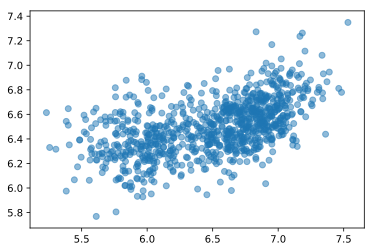

In [23]:
plt.scatter(y,best_model.predict(X), alpha=0.5);